# Libraries

In [1]:
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna

import warnings

In [3]:
url_train = 'https://drive.google.com/file/d/1bgioAJImsRbghdeMeJ0xMkW0XiMe_MZX/view?usp=drive_link'

train_file_id = url_train.split('/')[-2]

dwn_url_train ='https://drive.google.com/uc?id=' + train_file_id

df = pd.read_csv(dwn_url_train)

# Data Information

In [4]:
df.head()

,Number,Sex,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,1,M,43.2555,30.8421,25.9025,6.3,Yes
1,2,F,45.6033,28.1900,26.2067,13.5,No
2,3,F,45.0107,28.9677,26.0215,11.7,No
3,4,F,44.5398,28.9899,26.4703,13.5,No
4,5,M,43.2870,30.6972,26.0158,12.4,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Number        104 non-null    int64  
 1   Sex           104 non-null    object 
 2   %Red Pixel    104 non-null    float64
 3   %Green pixel  104 non-null    float64
 4   %Blue pixel   104 non-null    float64
 5   Hb            104 non-null    float64
 6   Anaemic       104 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.8+ KB


In [6]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
for col in obj:
    print(f"====={col}=====")
    unique_values = df[col].unique()
    n_unique_values = df[col].nunique()

    print(f"Unique values in {col}: {unique_values}")
    print(f"Number of unique values in {col}: {n_unique_values}\n")

=====Sex=====
Unique values in Sex: ['M' 'F' 'F ' 'M ']
Number of unique values in Sex: 4

=====Anaemic=====
Unique values in Anaemic: ['Yes' 'No']
Number of unique values in Anaemic: 2



# Data Preprocessing

## Rename Column

In [7]:
rename_cols = {'%Red Pixel': 'Red Pixel', '%Green pixel': 'Green pixel', '%Blue pixel': 'Blue pixel'}
df.rename(columns = rename_cols, inplace = True)

## Replacing Values

In [8]:
df['Sex'] = df['Sex'].replace({'F ': 'F', 'M ': 'M'})
df['Sex'].head()

0    M
1    F
2    F
3    F
4    M
Name: Sex, dtype: object

# EDA

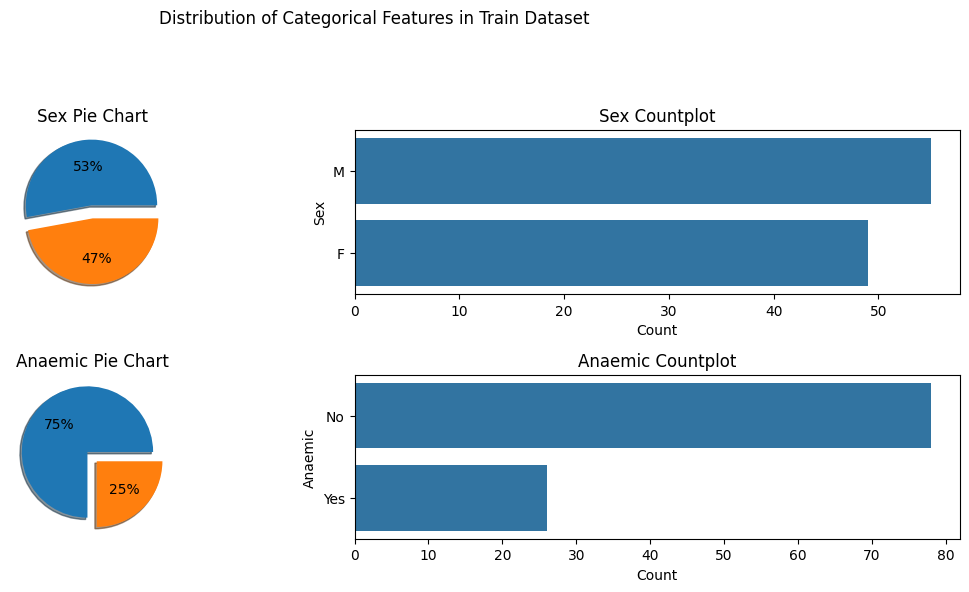

In [9]:
obj = [col for col in df.columns if df[col].nunique() < 10]

fig, axes = plt.subplots(len(obj),2, figsize = (12,3 * len(obj)))

for i, col in enumerate(obj):
  ax = axes[i, 0]
  ax.pie(
      df[col].value_counts(),
      shadow = True,
      explode = [0.1 for _ in range(df[col].nunique())],
      autopct='%1.f%%'
  )
  ax.set_aspect('equal')
  ax.set_title(f'{col} Pie Chart')

  ax1 = axes[i, 1]
  sns.countplot(y = col, ax = ax1, order = df[col].value_counts().index, data = df)
  ax1.set_xlabel('Count')
  ax1.set_ylabel(col)
  ax1.set_title(f'{col} Countplot')

fig.suptitle('Distribution of Categorical Features in Train Dataset\n\n\n')
plt.tight_layout()
plt.show()

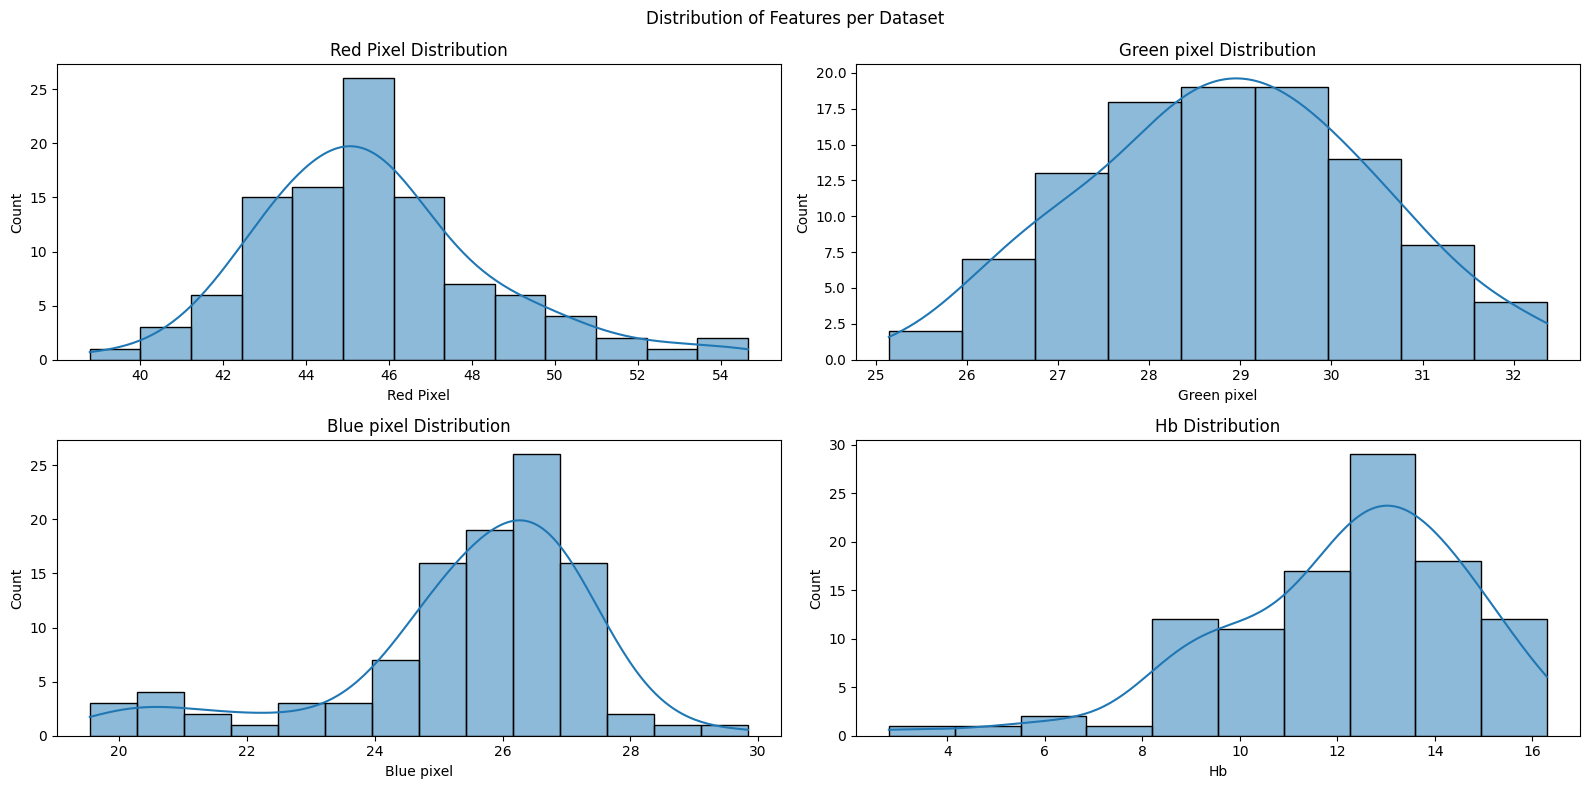

In [10]:
columns = [col for col in df.columns if df[col].dtype in ['float64', 'int64'] and col not in ['Number']]
fig, axes = plt.subplots(2,2, figsize = (16,8))
axes = axes.flatten()
for i, col in enumerate(columns):
  ax = sns.histplot(data = df, x = col , ax = axes[i], kde = True)

  ax.set_title(f'{col} Distribution')
  ax.set_xlabel(f'{col}')

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

fig.suptitle('Distribution of Features per Dataset')
plt.tight_layout()
plt.show()

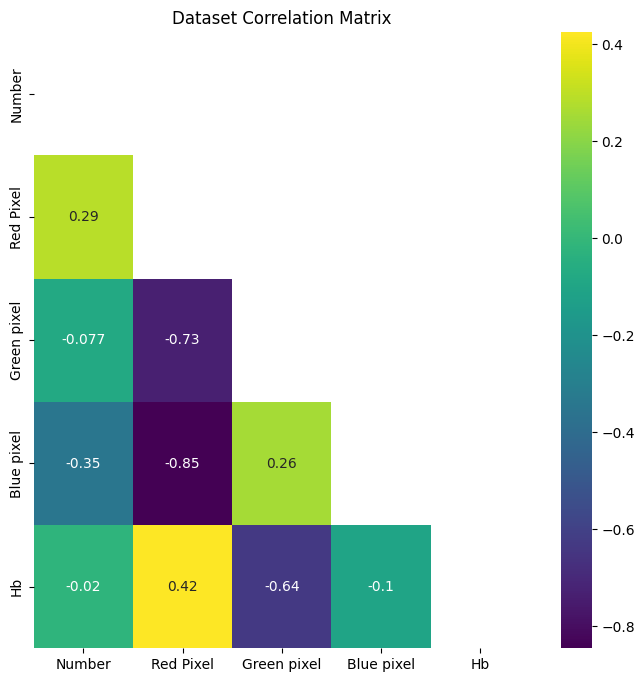

In [11]:
columns = [col for col in df.columns if col not in ['id'] and df[col].dtype in ['int64', 'float64']]

corr = df[columns].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (8,8))
sns.heatmap(corr, mask = mask, cmap ='viridis', annot = True)
plt.title('Dataset Correlation Matrix')
plt.show()

# Data Preprocessing Part II

In [12]:
le = LabelEncoder()
cols = ['Sex', 'Anaemic']
for i in cols:
  df[i] = le.fit_transform(df[i])

df.head()

,Number,Sex,Red Pixel,Green pixel,Blue pixel,Hb,Anaemic
0,1,1,43.2555,30.8421,25.9025,6.3,1
1,2,0,45.6033,28.1900,26.2067,13.5,0
2,3,0,45.0107,28.9677,26.0215,11.7,0
3,4,0,44.5398,28.9899,26.4703,13.5,0
4,5,1,43.2870,30.6972,26.0158,12.4,0


## Train Test Split

In [13]:
features = [col for col in df.columns if col not in ['Number', 'Anaemic']]
target = 'Anaemic'

X = df[features]
y = df['Anaemic']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size =  0.2, random_state = 42)

# Data Modelling

In [14]:
def crossval(model, n_splits):
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
  scores = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_test_pred)
    print(f"Fold {fold + 1}: RF Accuracy Score: {score}")
    scores.append(score)

  avg_score = np.mean(scores)
  print(f"Average Accuracy score: {avg_score}")
  return avg_score

In [15]:
def objective_rf(trial):
  rf_params = {
      "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
      "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
      "max_depth": trial.suggest_int("max_depth", 4, 32),
      "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
      "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
      "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2']),
      "random_state": 42,
      "n_jobs": -1
  }
  model = RandomForestClassifier(**rf_params)
  avg_score = crossval(model, n_splits=5)
  return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=10)
best_params = study.best_params

[I 2024-07-15 09:11:38,963] A new study created in memory with name: no-name-cd4c12c7-2de5-4913-909b-3fabe2ba6e52


Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:11:41,462] Trial 0 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:11:51,203] Trial 1 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 400, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:02,198] Trial 2 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 500, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:04,467] Trial 3 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:09,127] Trial 4 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:10,718] Trial 5 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:13,838] Trial 6 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 0.9523809523809523
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:16,556] Trial 7 finished with value: 0.9619047619047618 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9619047619047618
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:19,114] Trial 8 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713
Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523


[I 2024-07-15 09:12:25,755] Trial 9 finished with value: 0.9714285714285713 and parameters: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9714285714285713.


Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713


In [16]:
final_rf_params = {
    'n_estimators': best_params['n_estimators'],
    'criterion': best_params['criterion'],
    'max_depth': best_params['max_depth'],
    'min_samples_split': best_params['min_samples_split'],
    'min_samples_leaf': best_params['min_samples_leaf'],
    'max_features': best_params['max_features'],
    'random_state': 42,
    'n_jobs': -1
}

final_model = RandomForestClassifier(**final_rf_params)
scores = crossval(model=final_model, n_splits=5)

Fold 1: RF Accuracy Score: 1.0
Fold 2: RF Accuracy Score: 0.9523809523809523
Fold 3: RF Accuracy Score: 0.9523809523809523
Fold 4: RF Accuracy Score: 0.9523809523809523
Fold 5: RF Accuracy Score: 1.0
Average Accuracy score: 0.9714285714285713


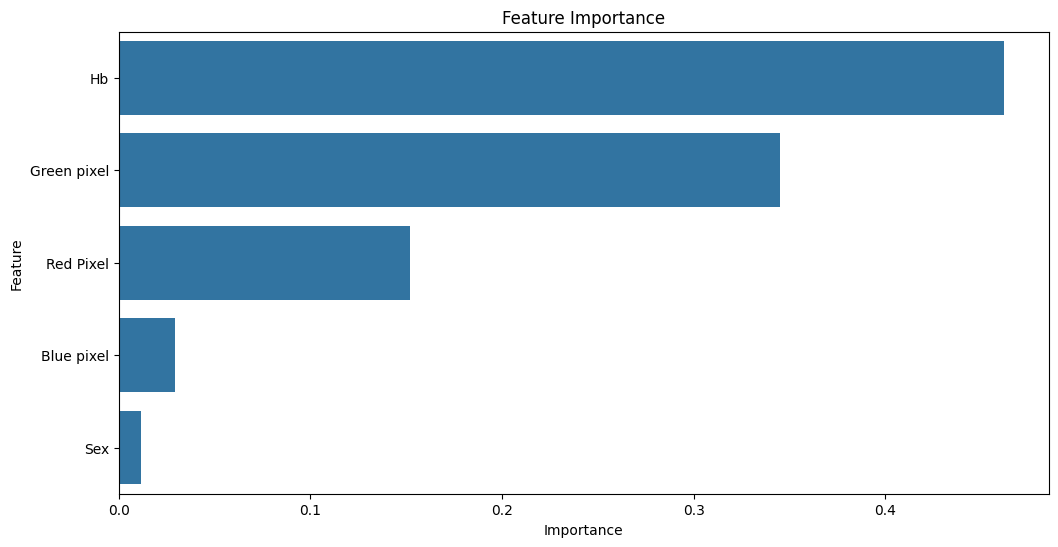

In [17]:
feature_importance = final_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()